In [1]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import cartopy.crs as crs
import cartopy.feature as cfeature
import requests
import os,sys
from mpl_toolkits.basemap import Basemap, cm, shiftgrid, addcyclic
import glob
import statsmodels.api as sm
import pymannkendall as mk
import xskillscore

In [2]:
file_path_rea = '/home/tiro/Data/atkins/activities/activity_2.1b/data/rea*/*/*/*/*/*/sadc/'
file_path_obs = '/home/tiro/Data/atkins/activities/activity_2.1b/data/*/*/*/*/*/*/sadc/'

files_rea = glob.glob(file_path_rea+'*era5.nc')
files_obs = glob.glob(file_path_obs+'*era5.nc')

In [3]:
### Annual sum files

file_path_obs_ann = '/home/tiro/Data/atkins/activities/activity_2.1b/data/*/*/*/*/*/*/sadc/regridded/'
files_obs_ann = sorted(glob.glob(file_path_obs_ann+'*ann.nc'))

files_obs_ann_clim = sorted(glob.glob(file_path_obs_ann+'*ann_clim.nc' ))
#files_obs_ann_clim

In [4]:
files_obs_ann

for ifile in files_obs_ann: 
    file_split=ifile.split("/")
    filename=file_split[-1]
    filename_split=filename.split("_")
    filename_base=filename.split(".")[0]
    institute=filename_split[2]  
    dataset=filename_split[3]
    
    print(institute+'_'+dataset)

CPC_ARC2
TAMSAT_RFE-filled-V3.1
CHC_CHIRPS-2.0-0p25
GPCC_full-data-first-guess
GPM_IMERG
GloH2O_mswep-v280
NOAA-CPC_CMORPH-CDR
ECMWF_ERA5


In [5]:
def get_linear(_y, what="slope"):
    # receives 
    # data need to be regularly spaced
    # returns slope in units of _y per unit of _x, intercept in units of _y or pvalue
    # pvalue is analytical, perhaps one day I will implement bootstrap 
    #
    # need to add constant for OLS does not include intercept by default 
    if not np.ma.is_masked(_y):
        _x = sm.add_constant(np.arange(len(_y)))
        res=sm.OLS(_y, _x, missing='none').fit()
        #res=sm.OLS(_y, _x, missing='drop').fit()
        if what=="slope":
            return res.params[1]
        elif what=="pval":
            return res.pvalues[1]    # results from the t_test, checking if the data follows a 
        elif what=="intercept":
            return res.params[0]
    else:
        return np.nan

In [6]:
def choose_var_trend(var):
        return {
        #'variable': ['min_ref', 'max_ref', 'step', 'min_bias', 'max_bias', 'step_bias', 'units']
        'pr'                                                        :  [ 150, 700, 50, -20, 20, 5],
        'precipitation'                                             :  [ 150, 700, 50, -20, 20, 5],
    }[var]

In [7]:
def choose_var_rsme(var):
        return {
        #'variable': ['min_ref', 'max_ref', 'step', 'min_bias', 'max_bias', 'step_biaas']
        'pr'                                                        :  [ 100, 1500, 100, 0, 500, 50],
        'precipitation'                                             :  [ 100, 1500, 100, 0, 500, 50],
    }[var]

In [8]:
def choose_var_corr(var):
        return {
        #'variable': ['min_ref', 'max_ref', 'step', 'min_bias', 'max_bias', 'step_biaas']
        'pr'                                                        :  [ 100, 1500, 100, -1, 1, .2],
        'precipitation'                                             :  [ 100, 1500, 100, -1, 1, .2],   
    }[var]

In [9]:
mask_file = glob.glob(file_path_rea+'era5_land_sea_mask_SA_no_lakes.nc')
mask = xr.open_dataset(mask_file[0]).pr

[array(6.01393795), array(2890.19628906)]


/tmp/ipykernel_14337/3237074703.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


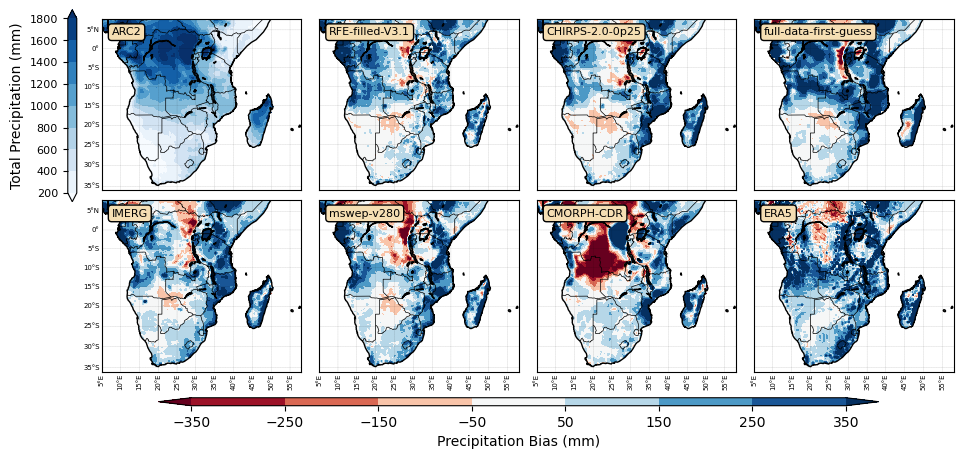

In [10]:
def choose_var_bias(var):
        return {
        #'variable': ['min_ref', 'max_ref', 'step', 'min_bias', 'max_bias', 'step_biaas']
        'pr'                                                        :  [ 200, 2000, 200, -350, 400, 100, 200, 2000, 400],
        'precipitation'                                             :  [ 200, 2000, 200, -350, 400, 100, 200, 2000, 400],
    }[var]
#fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(8,6))

year1 = str(2001)
year2 = str(2020)

#for index in indices:
#    print(index)
var = 'pr'
variables = ['pr']

observed_data = files_obs_ann_clim
ref_file = [observed_data[0]]
observed_data = observed_data[1:len(observed_data)]
ifile = ref_file[0]
#ax = fig.add_subplot(3, 2, i+1)

file_xr = xr.open_dataset(ifile)

#variables = list(file_xr.keys())

for var in variables:
    fig = plt.figure(figsize=(9,4))
    i=1
    ax = fig.add_subplot(2, 4, i)
    ifile = ref_file[0]
    file_split=ifile.split("/")
    filename=file_split[-1]
    filename_split=filename.split("_")
    filename_base=filename.split(".")[0]
    institute=filename_split[2]  
    dataset=filename_split[3]
    file_xr = xr.open_dataset(ifile)
    #units = file_xr[var].attrs['units']
    lons = file_xr.variables['longitude'][:]
    lats = file_xr.variables['latitude'][:]
    levs = np.arange(choose_var_bias(var)[0],choose_var_bias(var)[1], choose_var_bias(var)[2])
    map = Basemap ( projection ='mill',llcrnrlon=5,urcrnrlon=58, llcrnrlat=-36,urcrnrlat=8,resolution='l')
    x2d, y2d = map(*np.meshgrid(lons,lats))
    clim_var_ref = file_xr[var].sel(time=slice(year1,year2)).mean('time')
    clim_var_ref = clim_var_ref*mask
    pl1 = map.contourf(x2d,y2d,clim_var_ref[:,:],levs,extend='both',cmap='Blues')
    
    min_val = clim_var_ref.min().values
    max_val = clim_var_ref.max().values
    print([min_val, max_val])
    map.drawcoastlines()
    map.drawcountries()
    map.drawparallels(np.arange(-80., 81., 5), \
        labels=[1,0,0,0], fontsize=5,linewidth=0.1)
    map.drawmeridians(np.arange(-180., 181., 5),\
            labels=[0,0,0,0], fontsize=0,linewidth=0.1)

    props = dict(boxstyle='round', facecolor='wheat', alpha=1)
    ax.text(0.05, 0.95, dataset, fontsize=8, verticalalignment='top', transform=ax.transAxes, bbox=props)

    for ifile in observed_data: 
        i=i+1
        var = 'pr'
        ax = fig.add_subplot(2, 4, i)
        file_split=ifile.split("/")
        filename=file_split[-1]
        filename_split=filename.split("_")
        filename_base=filename.split(".")[0]
        institute=filename_split[2]  
        dataset=filename_split[3]
        file_xr = xr.open_dataset(ifile)
        lons = file_xr.variables['longitude'][:]
        lats = file_xr.variables['latitude'][:]
        if dataset == 'mswep-v280':
            var = 'precipitation'
        levs_1 = np.arange(choose_var_bias(var)[3],choose_var_bias(var)[4], choose_var_bias(var)[5])
        map = Basemap ( projection ='mill',llcrnrlon=5,urcrnrlon=58, llcrnrlat=-36,urcrnrlat=8,resolution='l')
        x2d, y2d = map(*np.meshgrid(lons,lats))
        clim_var = file_xr[var].sel(time=slice(year1,year2)).mean('time')
        clim_var_bias = clim_var - clim_var_ref
        clim_var_bias = clim_var_bias*mask
        min_val = clim_var_bias.min().values
        max_val = clim_var_bias.max().values

        #print([min_val, max_val])
        pl2 = map.contourf(x2d,y2d,clim_var_bias[:,:],levs_1,extend='both',cmap='RdBu')
        map.drawcoastlines()
        map.drawcountries()

        if i in [2,3,4]:
                map.drawparallels(np.arange(-80., 81., 5), \
                labels=[0,0,0,0], fontsize=0,linewidth=0.1)
                map.drawmeridians(np.arange(-180., 181., 5),\
                labels=[0,0,0,0], fontsize=0,linewidth=0.1)
        if i in [5]:
                map.drawparallels(np.arange(-80., 81., 5), \
                labels=[1,0,0,0], fontsize=5,linewidth=0.1)
                map.drawmeridians(np.arange(-180., 181., 5),\
                labels=[0,0,0,1], fontsize=5,linewidth=0.1, rotation=90)
        if i in [6,7,8,9]:
                map.drawparallels(np.arange(-80., 81., 5), \
                labels=[0,0,0,0], fontsize=0,linewidth=0.1)
                map.drawmeridians(np.arange(-180., 181., 5),\
                labels=[0,0,0,1], fontsize=5,linewidth=0.1, rotation=90)

        props = dict(boxstyle='round', facecolor='wheat', alpha=1)
        ax.text(0.05, 0.95, dataset, fontsize=8, verticalalignment='top', transform=ax.transAxes, bbox=props)
    #cax = plt.axes([0.93, 0.2, 0.01, 0.6])

        #bar.set_label('Temperature ($^\circ$C)',size=12)
        #bar.ax.tick_params(labelsize=8, zorder='right') 

    cax2 = fig.add_axes([-0.001, 0.5, 0.01, 0.48])   
    bar2 = fig.colorbar(pl1, cax=cax2, orientation='vertical', ticklocation = 'left', extend = 'max')
    bar2.set_label('Total Precipitation (mm)',size=10)
    bar2.ax.tick_params(labelsize=8) 
    #bar2.ax.tick_params(labelsize=8,labelleft='True', labelright = 'False', left = 'True', right = 'False')

    cax = fig.add_axes([0.1, -0.01, 0.8, 0.02])   
    bar = fig.colorbar(pl2, cax=cax, orientation='horizontal')
    bar.set_label('Precipitation Bias (mm)',size=10)
    plt.tight_layout()

    #fig.suptitle(var, fontsize=16, y=1.05)
    #fig.show()
    #plt.savefig('Images/prcptot/'+var+'_2001_2020.png', bbox_inches='tight',dpi=300)
    #fig.show()


In [ ]:
def choose_var_bias(var):
        return {
        #'variable': ['min_ref', 'max_ref', 'step', 'min_bias', 'max_bias', 'step_biaas']
        'pr'                                                        :  [ 200, 2000, 200, -350, 400, 100, 200, 2000, 400],
        'precipitation'                                             :  [ 200, 2000, 200, -350, 400, 100, 200, 2000, 400],
    }[var]
#fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(8,6))

year1 = str(1991)
year2 = str(2020)

#for index in indices:
#    print(index)
var = 'pr'
variables = ['pr']

observed_data = files_obs_ann
ref_file = [observed_data[0]]
observed_data = observed_data[1:len(observed_data)]
ifile = ref_file[0]
#ax = fig.add_subplot(3, 2, i+1)

file_xr = xr.open_dataset(ifile)

#variables = list(file_xr.keys())

for var in variables:
    fig = plt.figure(figsize=(9,4))
    i=1
    ax = fig.add_subplot(2, 4, i)
    ifile = ref_file[0]
    file_split=ifile.split("/")
    filename=file_split[-1]
    filename_split=filename.split("_")
    filename_base=filename.split(".")[0]
    institute=filename_split[2]  
    dataset=filename_split[3]
    file_xr = xr.open_dataset(ifile)
    #units = file_xr[var].attrs['units']
    lons = file_xr.variables['longitude'][:]
    lats = file_xr.variables['latitude'][:]
    levs = np.arange(choose_var_bias(var)[0],choose_var_bias(var)[1], choose_var_bias(var)[2])
    map = Basemap ( projection ='mill',llcrnrlon=5,urcrnrlon=58, llcrnrlat=-36,urcrnrlat=8,resolution='l')
    x2d, y2d = map(*np.meshgrid(lons,lats))
    clim_var_ref = file_xr[var].sel(time=slice(year1,year2)).mean('time')
    clim_var_ref = clim_var_ref*mask
    pl1 = map.contourf(x2d,y2d,clim_var_ref[:,:],levs,extend='both',cmap='Blues')
    
    min_val = clim_var_ref.min().values
    max_val = clim_var_ref.max().values
    print([min_val, max_val])
    map.drawcoastlines()
    map.drawcountries()
    map.drawparallels(np.arange(-80., 81., 5), \
        labels=[1,0,0,0], fontsize=5,linewidth=0.1)
    map.drawmeridians(np.arange(-180., 181., 5),\
            labels=[0,0,0,0], fontsize=0,linewidth=0.1)

    props = dict(boxstyle='round', facecolor='wheat', alpha=1)
    ax.text(0.05, 0.95, dataset, fontsize=8, verticalalignment='top', transform=ax.transAxes, bbox=props)

    for ifile in observed_data: 
        i=i+1
        var = 'pr'
        ax = fig.add_subplot(2, 4, i)
        file_split=ifile.split("/")
        filename=file_split[-1]
        filename_split=filename.split("_")
        filename_base=filename.split(".")[0]
        institute=filename_split[2]  
        dataset=filename_split[3]
        file_xr = xr.open_dataset(ifile)
        lons = file_xr.variables['longitude'][:]
        lats = file_xr.variables['latitude'][:]
        if dataset == 'mswep-v280':
            var = 'precipitation'
        levs_1 = np.arange(choose_var_bias(var)[3],choose_var_bias(var)[4], choose_var_bias(var)[5])
        map = Basemap ( projection ='mill',llcrnrlon=5,urcrnrlon=58, llcrnrlat=-36,urcrnrlat=8,resolution='l')
        x2d, y2d = map(*np.meshgrid(lons,lats))
        clim_var = file_xr[var].sel(time=slice(year1,year2)).mean('time')
        clim_var_bias = clim_var - clim_var_ref
        clim_var_bias = clim_var_bias*mask
        min_val = clim_var_bias.min().values
        max_val = clim_var_bias.max().values

        #print([min_val, max_val])
        pl2 = map.contourf(x2d,y2d,clim_var_bias[:,:],levs_1,extend='both',cmap='RdBu')
        map.drawcoastlines()
        map.drawcountries()

        if i in [2,3,4]:
                map.drawparallels(np.arange(-80., 81., 5), \
                labels=[0,0,0,0], fontsize=0,linewidth=0.1)
                map.drawmeridians(np.arange(-180., 181., 5),\
                labels=[0,0,0,0], fontsize=0,linewidth=0.1)
        if i in [5]:
                map.drawparallels(np.arange(-80., 81., 5), \
                labels=[1,0,0,0], fontsize=5,linewidth=0.1)
                map.drawmeridians(np.arange(-180., 181., 5),\
                labels=[0,0,0,1], fontsize=5,linewidth=0.1, rotation=90)
        if i in [6,7,8,9]:
                map.drawparallels(np.arange(-80., 81., 5), \
                labels=[0,0,0,0], fontsize=0,linewidth=0.1)
                map.drawmeridians(np.arange(-180., 181., 5),\
                labels=[0,0,0,1], fontsize=5,linewidth=0.1, rotation=90)

        props = dict(boxstyle='round', facecolor='wheat', alpha=1)
        ax.text(0.05, 0.95, dataset, fontsize=8, verticalalignment='top', transform=ax.transAxes, bbox=props)
    #cax = plt.axes([0.93, 0.2, 0.01, 0.6])

        #bar.set_label('Temperature ($^\circ$C)',size=12)
        #bar.ax.tick_params(labelsize=8, zorder='right') 

    cax2 = fig.add_axes([-0.001, 0.5, 0.01, 0.48])   
    bar2 = fig.colorbar(pl1, cax=cax2, orientation='vertical', ticklocation = 'left', extend = 'max')
    bar2.set_label('Total Precipitation (mm)',size=10)
    bar2.ax.tick_params(labelsize=8) 
    #bar2.ax.tick_params(labelsize=8,labelleft='True', labelright = 'False', left = 'True', right = 'False')

    cax = fig.add_axes([0.1, -0.01, 0.8, 0.02])   
    bar = fig.colorbar(pl2, cax=cax, orientation='horizontal')
    bar.set_label('Precipitation Bias (mm)',size=10)
    plt.tight_layout()

    #fig.suptitle(var, fontsize=16, y=1.05)
    #fig.show()
    #plt.savefig('Images/prcptot/'+var+'_1.png', bbox_inches='tight',dpi=300)
    #fig.show()


[array(6.01393795), array(2890.19604492)]


In [ ]:
def choose_var_bias(var):
        return {
        #'variable': ['min_ref', 'max_ref', 'step', 'min_bias', 'max_bias', 'step_biaas']
        'pr'                                                        :  [ 200, 2000, 200, -140, 150, 40, 200, 2000, 400],
        'precipitation'                                             :  [ 200, 2000, 200, -140, 150, 40, 200, 2000, 400],
    }[var]
#fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(8,6))

year1 = str(1991)
year2 = str(2020)

year1_1 = str(2001)
year2_1 = str(2020)

#for index in indices:
#    print(index)
var = 'pr'
variables = ['pr']

observed_data = files_obs_ann
ref_file = [observed_data[0]]
observed_data = observed_data[1:len(observed_data)]
ifile = ref_file[0]
#ax = fig.add_subplot(3, 2, i+1)

file_xr = xr.open_dataset(ifile)

#variables = list(file_xr.keys())

for var in variables:
    fig = plt.figure(figsize=(9,4))
    i=1
    ax = fig.add_subplot(2, 4, i)
    ifile = ref_file[0]
    file_split=ifile.split("/")
    filename=file_split[-1]
    filename_split=filename.split("_")
    filename_base=filename.split(".")[0]
    institute=filename_split[2]  
    dataset=filename_split[3]
    file_xr = xr.open_dataset(ifile)
    
    #units = file_xr[var].attrs['units']
    lons = file_xr.variables['longitude'][:]
    lats = file_xr.variables['latitude'][:]
    levs = np.arange(choose_var_bias(var)[3],choose_var_bias(var)[4], choose_var_bias(var)[5])
    map = Basemap ( projection ='mill',llcrnrlon=5,urcrnrlon=58, llcrnrlat=-36,urcrnrlat=8,resolution='l')
    x2d, y2d = map(*np.meshgrid(lons,lats))
    #clim_var_ref = file_xr[var].mean('time')
    clim_var_1 = file_xr[var].sel(time=slice(year1,year2)).mean('time')
    clim_var_2 = file_xr[var].sel(time=slice(year1_1,year2)).mean('time')
    clim_var_ref = clim_var_1 - clim_var_2
    clim_var_ref = clim_var_ref*mask
    pl1 = map.contourf(x2d,y2d,clim_var_ref[:,:],levs,extend='both',cmap='RdBu')
    
    min_val = clim_var_ref.min().values
    max_val = clim_var_ref.max().values
    print([str(file_xr[var].sel(time=slice(year1,year2)).time.min().dt.year.values), str(file_xr[var].sel(time=slice(year1_1,year2)).time.min().dt.year.values), min_val, max_val])
    map.drawcoastlines()
    map.drawcountries()
    map.drawparallels(np.arange(-80., 81., 5), \
        labels=[1,0,0,0], fontsize=5,linewidth=0.1)
    map.drawmeridians(np.arange(-180., 181., 5),\
            labels=[0,0,0,0], fontsize=0,linewidth=0.1)

    props = dict(boxstyle='round', facecolor='wheat', alpha=1)
    ax.text(0.05, 0.95, dataset, fontsize=8, verticalalignment='top', transform=ax.transAxes, bbox=props)

    for ifile in observed_data: 
        i=i+1
        var = 'pr'
        ax = fig.add_subplot(2, 4, i)
        file_split=ifile.split("/")
        filename=file_split[-1]
        filename_split=filename.split("_")
        filename_base=filename.split(".")[0]
        institute=filename_split[2]  
        dataset=filename_split[3]
        file_xr = xr.open_dataset(ifile)
        str(file_xr.time.min().dt.year.values)
        lons = file_xr.variables['longitude'][:]
        lats = file_xr.variables['latitude'][:]
        if dataset == 'mswep-v280':
            var = 'precipitation'
        levs_1 = np.arange(choose_var_bias(var)[3],choose_var_bias(var)[4], choose_var_bias(var)[5])
        map = Basemap ( projection ='mill',llcrnrlon=5,urcrnrlon=58, llcrnrlat=-36,urcrnrlat=8,resolution='l')
        x2d, y2d = map(*np.meshgrid(lons,lats))
        clim_var_1 = file_xr[var].sel(time=slice(year1,year2)).mean('time')
        clim_var_2 = file_xr[var].sel(time=slice(year1_1,year2)).mean('time')
        clim_var_bias = clim_var_1 - clim_var_2
        clim_var_bias = clim_var_bias*mask
        min_val = clim_var_bias.min().values
        max_val = clim_var_bias.max().values

        print([str(file_xr[var].sel(time=slice(year1,year2)).time.min().dt.year.values), str(file_xr[var].sel(time=slice(year1_1,year2)).time.min().dt.year.values), min_val, max_val])

        pl2 = map.contourf(x2d,y2d,clim_var_bias[:,:],levs_1,extend='both',cmap='RdBu')
        map.drawcoastlines()
        map.drawcountries()

        if i in [2,3,4]:
                map.drawparallels(np.arange(-80., 81., 5), \
                labels=[0,0,0,0], fontsize=0,linewidth=0.1)
                map.drawmeridians(np.arange(-180., 181., 5),\
                labels=[0,0,0,0], fontsize=0,linewidth=0.1)
        if i in [5]:
                map.drawparallels(np.arange(-80., 81., 5), \
                labels=[1,0,0,0], fontsize=5,linewidth=0.1)
                map.drawmeridians(np.arange(-180., 181., 5),\
                labels=[0,0,0,1], fontsize=5,linewidth=0.1, rotation=90)
        if i in [6,7,8,9]:
                map.drawparallels(np.arange(-80., 81., 5), \
                labels=[0,0,0,0], fontsize=0,linewidth=0.1)
                map.drawmeridians(np.arange(-180., 181., 5),\
                labels=[0,0,0,1], fontsize=5,linewidth=0.1, rotation=90)

        props = dict(boxstyle='round', facecolor='wheat', alpha=1)
        ax.text(0.05, 0.95, dataset, fontsize=8, verticalalignment='top', transform=ax.transAxes, bbox=props)
    #cax = plt.axes([0.93, 0.2, 0.01, 0.6])

        #bar.set_label('Temperature ($^\circ$C)',size=12)
        #bar.ax.tick_params(labelsize=8, zorder='right') 

    #cax2 = fig.add_axes([-0.001, 0.5, 0.01, 0.48])   
    #bar2 = fig.colorbar(pl1, cax=cax2, orientation='vertical', ticklocation = 'left', extend = 'max')
    #bar2.set_label('Total Precipitation (mm)',size=10)
    #bar2.ax.tick_params(labelsize=8) 
    #bar2.ax.tick_params(labelsize=8,labelleft='True', labelright = 'False', left = 'True', right = 'False')

    cax = fig.add_axes([0.1, -0.01, 0.8, 0.02])   
    bar = fig.colorbar(pl2, cax=cax, orientation='horizontal')
    bar.set_label('Precipitation Difference (mm)',size=10)
    plt.tight_layout()

    #fig.suptitle(var, fontsize=16, y=1.05)
    #fig.show()
    #plt.savefig('Images/prcptot/'+var+'_1991_2020_v_2001_2020.png', bbox_inches='tight',dpi=300)
    #fig.show()


In [ ]:

#fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(8,6))

year1 = str(2001)
year2 = str(2020)



#for index in indices:
#    print(index)
var = 'pr'
variables = ['pr']

observed_data = files_obs_ann
ref_file = [observed_data[0]]
observed_data = observed_data[1:len(observed_data)]
ifile = ref_file[0]
#ax = fig.add_subplot(3, 2, i+1)

file_xr = xr.open_dataset(ifile)

#variables = list(file_xr.keys())

for var in variables:
    fig = plt.figure(figsize=(9,4))
    i=1
    ax = fig.add_subplot(2, 4, i)
    ifile = ref_file[0]
    file_split=ifile.split("/")
    filename=file_split[-1]
    filename_split=filename.split("_")
    filename_base=filename.split(".")[0]
    institute=filename_split[2]  
    dataset=filename_split[3]
    file_xr = xr.open_dataset(ifile)
    #units = file_xr[var].attrs['units']
    lons = file_xr.variables['longitude'][:]
    lats = file_xr.variables['latitude'][:]
    levs = np.arange(choose_var_bias(var)[0],choose_var_bias(var)[1], choose_var_bias(var)[2])
    map = Basemap ( projection ='mill',llcrnrlon=5,urcrnrlon=58, llcrnrlat=-36,urcrnrlat=8,resolution='l')
    x2d, y2d = map(*np.meshgrid(lons,lats))
    clim_var_ref = file_xr[var]
    clim_var_ref =clim_var_ref.mean('time')
    clim_var_ref = clim_var_ref*mask
    pl1 = map.contourf(x2d,y2d,clim_var_ref[:,:],levs,extend='both',cmap='Blues')
    min_val = clim_var_ref.min().values
    max_val = clim_var_ref.max().values
    print([min_val, max_val])
    map.drawcoastlines()
    map.drawcountries()
    map.drawparallels(np.arange(-80., 81., 5), \
        labels=[1,0,0,0], fontsize=5,linewidth=0.1)
    map.drawmeridians(np.arange(-180., 181., 5),\
            labels=[0,0,0,0], fontsize=0,linewidth=0.1)

    props = dict(boxstyle='round', facecolor='wheat', alpha=1)
    ax.text(0.05, 0.95, dataset, fontsize=8, verticalalignment='top', transform=ax.transAxes, bbox=props)

    for ifile in observed_data: 
        i=i+1
        var = 'pr'
        ax = fig.add_subplot(2, 4, i)
        file_split=ifile.split("/")
        filename=file_split[-1]
        filename_split=filename.split("_")
        filename_base=filename.split(".")[0]
        institute=filename_split[2]  
        dataset=filename_split[3]
        print(dataset)
        file_xr = xr.open_dataset(ifile)
        lons = file_xr.variables['longitude'][:]
        lats = file_xr.variables['latitude'][:]
        if dataset == 'mswep-v280':
            var = 'precipitation'
        levs_1 = np.arange(choose_var_bias(var)[3],choose_var_bias(var)[4], choose_var_bias(var)[5])
        map = Basemap ( projection ='mill',llcrnrlon=5,urcrnrlon=58, llcrnrlat=-36,urcrnrlat=8,resolution='l')
        x2d, y2d = map(*np.meshgrid(lons,lats))
        clim_var = file_xr[var]
        clim_var = clim_var.mean('time')
        clim_var = clim_var*mask
        clim_var_bias = clim_var - clim_var_ref
        min_val = clim_var.min().values
        max_val = clim_var.max().values

        print([min_val, max_val])
        pl2 = map.contourf(x2d,y2d,clim_var[:,:],levs,extend='both',cmap='Blues')
        map.drawcoastlines()
        map.drawcountries()

        if i in [2,3,4]:
                map.drawparallels(np.arange(-80., 81., 5), \
                labels=[0,0,0,0], fontsize=0,linewidth=0.1)
                map.drawmeridians(np.arange(-180., 181., 5),\
                labels=[0,0,0,0], fontsize=0,linewidth=0.1)
        if i in [5]:
                map.drawparallels(np.arange(-80., 81., 5), \
                labels=[1,0,0,0], fontsize=5,linewidth=0.1)
                map.drawmeridians(np.arange(-180., 181., 5),\
                labels=[0,0,0,1], fontsize=5,linewidth=0.1, rotation=90)
        if i in [6,7,8,9]:
                map.drawparallels(np.arange(-80., 81., 5), \
                labels=[0,0,0,0], fontsize=0,linewidth=0.1)
                map.drawmeridians(np.arange(-180., 181., 5),\
                labels=[0,0,0,1], fontsize=5,linewidth=0.1, rotation=90)

        props = dict(boxstyle='round', facecolor='wheat', alpha=1)
        ax.text(0.05, 0.95, dataset, fontsize=8, verticalalignment='top', transform=ax.transAxes, bbox=props)

    cax = fig.add_axes([0.1, -0.01, 0.8, 0.02])   
    bar = fig.colorbar(pl2, cax=cax, orientation='horizontal')
    bar.set_label('Total Precipitation (mm)',size=10)
    plt.tight_layout()

    #fig.suptitle(var, fontsize=16, y=1.05)
    #fig.show()
    #plt.savefig('Images/prcptot/'+var+'_no_bias_2001_2020.png', bbox_inches='tight',dpi=300)



In [ ]:
def choose_var_rsme(var):
        return {
        #'variable': ['min_ref', 'max_ref', 'step', 'min_bias', 'max_bias', 'step_biaas']
        'pr'                                                        :  [ 100, 1500, 100, 100, 500, 50],
        'precipitation'                                             :  [ 100, 1500, 100, 100, 500, 50],
    }[var]
#fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(8,6))
def choose_var_rsme(var):
        return {
        #'variable': ['min_ref', 'max_ref', 'step', 'min_bias', 'max_bias', 'step_biaas']
        'pr'                                                        :  [ 100, 1500, 100, 0.2, 1.5, 0.1],
        'precipitation'                                             :  [ 100, 1500, 100, 0.2, 1.5, 0.1],
    }[var]
year1 = str(2001)
year2 = str(2020)



#for index in indices:
#    print(index)
var = 'pr'
variables = ['pr']

observed_data = files_obs_ann
ref_file = [observed_data[0]]
observed_data = observed_data[1:len(observed_data)]
ifile = ref_file[0]
#ax = fig.add_subplot(3, 2, i+1)

file_xr = xr.open_dataset(ifile)

#variables = list(file_xr.keys())

for var in variables:
    fig = plt.figure(figsize=(9,4))
    i=1
    ax = fig.add_subplot(2, 4, i)
    ifile = ref_file[0]
    file_split=ifile.split("/")
    filename=file_split[-1]
    filename_split=filename.split("_")
    filename_base=filename.split(".")[0]
    institute=filename_split[2]  
    dataset=filename_split[3]
    file_xr = xr.open_dataset(ifile)
    #units = file_xr[var].attrs['units']
    lons = file_xr.variables['longitude'][:]
    lats = file_xr.variables['latitude'][:]
    levs = np.arange(choose_var_bias(var)[0],choose_var_bias(var)[1], choose_var_bias(var)[2])
    map = Basemap ( projection ='mill',llcrnrlon=5,urcrnrlon=58, llcrnrlat=-36,urcrnrlat=8,resolution='l')
    x2d, y2d = map(*np.meshgrid(lons,lats))
    clim_var_ref = file_xr[var].sel(time=slice(year1,year2))
    clim_var_ref = clim_var_ref*mask
    #clim_var_ref =clim_var_ref.resample(time='1M').sum('time')
    clim_var_ref_1 =clim_var_ref.resample(time='1Y').sum().mean('time')
    
    #clim_var_ref = file_xr_ref[var].sel(time=slice(year1,year2))
    #clim_var_ref1 = file_xr_ref[var].sel(time=slice(year1,year2)).mean('time')

    pl1 = map.contourf(x2d,y2d,clim_var_ref_1[:,:],levs,extend='both',cmap='Blues')
    min_val = clim_var_ref.min().values
    max_val = clim_var_ref.max().values
    print([min_val, max_val])
    map.drawcoastlines()
    map.drawcountries()
    map.drawparallels(np.arange(-80., 81., 5), \
        labels=[1,0,0,0], fontsize=5,linewidth=0.1)
    map.drawmeridians(np.arange(-180., 181., 5),\
            labels=[0,0,0,0], fontsize=0,linewidth=0.1)

    props = dict(boxstyle='round', facecolor='wheat', alpha=1)
    ax.text(0.05, 0.95, dataset, fontsize=8, verticalalignment='top', transform=ax.transAxes, bbox=props)

    for ifile in observed_data: 
        i=i+1
        var = 'pr'
        ax = fig.add_subplot(2, 4, i)
        file_split=ifile.split("/")
        filename=file_split[-1]
        filename_split=filename.split("_")
        filename_base=filename.split(".")[0]
        institute=filename_split[2]  
        dataset=filename_split[3]
        print(dataset)
        file_xr = xr.open_dataset(ifile)
        lons = file_xr.variables['longitude'][:]
        lats = file_xr.variables['latitude'][:]
        if dataset == 'mswep-v280':
            var = 'precipitation'
        levs_1 = np.arange(choose_var_rsme(var)[3],choose_var_rsme(var)[4], choose_var_rsme(var)[5])
        map = Basemap ( projection ='mill',llcrnrlon=5,urcrnrlon=58, llcrnrlat=-36,urcrnrlat=8,resolution='l')
        x2d, y2d = map(*np.meshgrid(lons,lats))
        clim_var = file_xr[var].sel(time=slice(year1,year2))
        clim_var = clim_var*mask
        #clim_var = clim_var.resample(time='1M').sum('time')
        #clim_var = clim_var.mean('time')
        clim_var_rsme = xskillscore.rmse(clim_var_ref.resample(time="1Y").mean(),
                                         clim_var.resample(time="1Y").mean(),dim='time', skipna=True)
        clim_var_rsme = clim_var_rsme/(clim_var.max('time') - clim_var.min('time'))
        #clim_var_bias = clim_var - clim_var_ref
        min_val = clim_var_rsme.min().values
        max_val = clim_var_rsme.max().values

        print([min_val, max_val])
        pl2 = map.contourf(x2d,y2d,clim_var_rsme[:,:],levs_1,extend='both',cmap='coolwarm')
        map.drawcoastlines()
        map.drawcountries()

        if i in [2,3,4]:
                map.drawparallels(np.arange(-80., 81., 5), \
                labels=[0,0,0,0], fontsize=0,linewidth=0.1)
                map.drawmeridians(np.arange(-180., 181., 5),\
                labels=[0,0,0,0], fontsize=0,linewidth=0.1)
        if i in [5]:
                map.drawparallels(np.arange(-80., 81., 5), \
                labels=[1,0,0,0], fontsize=5,linewidth=0.1)
                map.drawmeridians(np.arange(-180., 181., 5),\
                labels=[0,0,0,1], fontsize=5,linewidth=0.1, rotation=90)
        if i in [6,7,8,9]:
                map.drawparallels(np.arange(-80., 81., 5), \
                labels=[0,0,0,0], fontsize=0,linewidth=0.1)
                map.drawmeridians(np.arange(-180., 181., 5),\
                labels=[0,0,0,1], fontsize=5,linewidth=0.1, rotation=90)

        props = dict(boxstyle='round', facecolor='wheat', alpha=1)
        ax.text(0.05, 0.95, dataset, fontsize=8, verticalalignment='top', transform=ax.transAxes, bbox=props)

    cax2 = fig.add_axes([-0.001, 0.5, 0.01, 0.48])    
    bar2 = fig.colorbar(pl1, cax=cax2, orientation='vertical', ticklocation = 'left', extend = 'max')
    bar2.set_label('Total Precipitation (mm)',size=10)
    bar2.ax.tick_params(labelsize=8) 
    #bar2.ax.tick_params(labelsize=8,labelleft='True', labelright = 'False', left = 'True', right = 'False')

    cax = fig.add_axes([0.1, -0.01, 0.8, 0.02])   
    bar = fig.colorbar(pl2, cax=cax, orientation='horizontal', extend = 'min')
    bar.set_label('Normalised RMSE ',size=12)
    plt.tight_layout()
    #fig.suptitle(var, fontsize=16, y=1.05)
    #fig.show()
    #plt.savefig('Images/prcptot/'+var+'_rsme.png', bbox_inches='tight',dpi=300)



In [ ]:
def choose_var_corr(var):
        return {
        #'variable': ['min_ref', 'max_ref', 'step', 'min_bias', 'max_bias', 'step_biaas']
        'pr'                                                        :  [ 200, 1800, 200, -.9, 1.1, .2],
        'precipitation'                                             :  [ 200, 1800, 200, -.9, 1.1, .2],   
    }[var]
#fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(8,6))

year1 = str(2001)
year2 = str(2020)



#for index in indices:
#    print(index)
var = 'pr'
variables = ['pr']

observed_data = files_obs_ann
ref_file = [observed_data[0]]
observed_data = observed_data[1:len(observed_data)]
ifile = ref_file[0]
#ax = fig.add_subplot(3, 2, i+1)

file_xr = xr.open_dataset(ifile)

#variables = list(file_xr.keys())

for var in variables:
    fig = plt.figure(figsize=(9,4))
    i=1
    ax = fig.add_subplot(2, 4, i)
    ifile = ref_file[0]
    file_split=ifile.split("/")
    filename=file_split[-1]
    filename_split=filename.split("_")
    filename_base=filename.split(".")[0]
    institute=filename_split[2]  
    dataset=filename_split[3]
    file_xr = xr.open_dataset(ifile)
    #units = file_xr[var].attrs['units']
    lons = file_xr.variables['longitude'][:]
    lats = file_xr.variables['latitude'][:]
    levs = np.arange(choose_var_corr(var)[0],choose_var_corr(var)[1], choose_var_corr(var)[2])
    map = Basemap ( projection ='mill',llcrnrlon=5,urcrnrlon=58, llcrnrlat=-36,urcrnrlat=8,resolution='l')
    x2d, y2d = map(*np.meshgrid(lons,lats))
    clim_var_ref = file_xr[var]
    clim_var_ref = clim_var_ref*mask
    clim_var_ref_1 =clim_var_ref.resample(time='1Y').sum().mean('time')
    
    #clim_var_ref = file_xr_ref[var].sel(time=slice(year1,year2))
    #clim_var_ref1 = file_xr_ref[var].sel(time=slice(year1,year2)).mean('time')

    pl1 = map.contourf(x2d,y2d,clim_var_ref_1[:,:],levs,extend='both',cmap='Blues')
    min_val = clim_var_ref.min().values
    max_val = clim_var_ref.max().values
    print([min_val, max_val])
    map.drawcoastlines()
    map.drawcountries()
    map.drawparallels(np.arange(-80., 81., 5), \
        labels=[1,0,0,0], fontsize=5,linewidth=0.1)
    map.drawmeridians(np.arange(-180., 181., 5),\
            labels=[0,0,0,0], fontsize=0,linewidth=0.1)

    props = dict(boxstyle='round', facecolor='wheat', alpha=1)
    ax.text(0.05, 0.95, dataset, fontsize=8, verticalalignment='top', transform=ax.transAxes, bbox=props)

    for ifile in observed_data: 
        i=i+1
        var = 'pr'
        ax = fig.add_subplot(2, 4, i)
        file_split=ifile.split("/")
        filename=file_split[-1]
        filename_split=filename.split("_")
        filename_base=filename.split(".")[0]
        institute=filename_split[2]  
        dataset=filename_split[3]
        file_xr = xr.open_dataset(ifile)
        lons = file_xr.variables['longitude'][:]
        lats = file_xr.variables['latitude'][:]
        if dataset == 'mswep-v280':
            var = 'precipitation'
        levs_1 = np.arange(choose_var_corr(var)[3],choose_var_corr(var)[4], choose_var_corr(var)[5])
        map = Basemap ( projection ='mill',llcrnrlon=5,urcrnrlon=58, llcrnrlat=-36,urcrnrlat=8,resolution='l')
        x2d, y2d = map(*np.meshgrid(lons,lats))
        clim_var = file_xr[var].sel(time=slice(year1,year2))
        clim_var = clim_var*mask
        clim_var_corr = xr.corr(clim_var_ref.resample(time="1Y").mean(),
                                clim_var.resample(time="1Y").mean(),dim='time')
        #clim_var_bias = clim_var - clim_var_ref
        min_val = clim_var_corr.min().values
        max_val = clim_var_corr.max().values

        print([min_val, max_val])
        pl2 = map.contourf(x2d,y2d,clim_var_corr[:,:],levs_1,extend='both',cmap='RdBu_r')
        map.drawcoastlines()
        map.drawcountries()

        if i in [2,3,4]:
                map.drawparallels(np.arange(-80., 81., 5), \
                labels=[0,0,0,0], fontsize=0,linewidth=0.1)
                map.drawmeridians(np.arange(-180., 181., 5),\
                labels=[0,0,0,0], fontsize=0,linewidth=0.1)
        if i in [5]:
                map.drawparallels(np.arange(-80., 81., 5), \
                labels=[1,0,0,0], fontsize=5,linewidth=0.1)
                map.drawmeridians(np.arange(-180., 181., 5),\
                labels=[0,0,0,1], fontsize=5,linewidth=0.1, rotation=90)
        if i in [6,7,8,9]:
                map.drawparallels(np.arange(-80., 81., 5), \
                labels=[0,0,0,0], fontsize=0,linewidth=0.1)
                map.drawmeridians(np.arange(-180., 181., 5),\
                labels=[0,0,0,1], fontsize=5,linewidth=0.1, rotation=90)

        props = dict(boxstyle='round', facecolor='wheat', alpha=1)
        ax.text(0.05, 0.95, dataset, fontsize=8, verticalalignment='top', transform=ax.transAxes, bbox=props)

    cax2 = fig.add_axes([-0.001, 0.5, 0.01, 0.48])   
    bar2 = fig.colorbar(pl1, cax=cax2, orientation='vertical', ticklocation = 'left', extend = 'max')
    bar2.set_label('Total Precipitation (mm)',size=10)
    bar2.ax.tick_params(labelsize=8) 
    #bar2.ax.tick_params(labelsize=8,labelleft='True', labelright = 'False', left = 'True', right = 'False')

    cax = fig.add_axes([0.1, -0.01, 0.8, 0.02])   
    bar = fig.colorbar(pl2, cax=cax, orientation='horizontal')
    bar.set_label('Correlation - Coefficient',size=12)
    plt.tight_layout()
    #fig.suptitle(var, fontsize=16, y=1.05)
    #fig.show()
    #plt.savefig('Images/prcptot/'+var+'_corr_ann.png', bbox_inches='tight',dpi=300)



In [ ]:
from time import process_time
t1_start = process_time()

def choose_var_trend(var):
        return {
        #'variable': ['min_ref', 'max_ref', 'step', 'min_bias', 'max_bias', 'step_bias', 'units']
        'pr'                                                        :  [ 150, 700, 50, -18, 20, 4],
        'precipitation'                                             :  [ 150, 700, 50, -18, 20, 4],
    }[var]


hatches = ['...', None,None,None,None,None,None,None, None,None, None, None,None,None,None,None,None,None,None,None]
levs_pval = np.arange(0,1,0.05)
#fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(8,6))

year1 = str(2001)
year2 = str(2020)

var = 'pr'
variables = ['pr']

observed_data = files_obs_ann
ref_file = [observed_data[0]]
observed_data = observed_data[1:len(observed_data)]
ifile = ref_file[0]
#ax = fig.add_subplot(3, 2, i+1)

file_xr = xr.open_dataset(ifile)

#variables = list(file_xr.keys())

for var in variables:
    break
    fig = plt.figure(figsize=(9,4))
    i=1
    ax = fig.add_subplot(2, 4, i)
    ifile = ref_file[0]
    file_split=ifile.split("/")
    filename=file_split[-1]
    filename_split=filename.split("_")
    filename_base=filename.split(".")[0]
    institute=filename_split[2]  
    dataset=filename_split[3]
    file_xr = xr.open_dataset(ifile)
    #units = file_xr[var].attrs['units']
    lons = file_xr.variables['longitude'][:]
    lats = file_xr.variables['latitude'][:]
    levs = np.arange(choose_var_trend(var)[3],choose_var_trend(var)[4], choose_var_trend(var)[5])
    map = Basemap ( projection ='mill',llcrnrlon=5,urcrnrlon=58, llcrnrlat=-36,urcrnrlat=8,resolution='l')
    x2d, y2d = map(*np.meshgrid(lons,lats))
    clim_var_ref = file_xr[var].sel(time=slice(year1,year2))
    clim_var_ref =clim_var_ref.resample(time='1Y').sum('time')
    clim_var_ref = clim_var_ref*mask
    
    output = []
    output_p = []
    output_t = []
    for l in np.arange(len(lats)):
        for m in np.arange(len(lons)):
            lon, lat = [lons[m], lats[l]]
            ts = clim_var_ref.sel(latitude = lat).sel(longitude = lon)
            #try:
            try:
                #slope_mk = mk.original_test(ts).slope
                slope_mk = mk.sens_slope(ts).slope
                trend_mk = mk.original_test(ts).trend
                slope_sig = mk.original_test(ts).p
                #print(trend_mk)

            except:
                slope_mk = np.nan
                slope_sig = np.nan
                trend_mk = np.nan
            output.append(slope_mk)
            output_p.append(slope_sig)
            output_t.append(trend_mk)

    output = np.copy(output).reshape(len(lats), len(lons))
    output_p = np.copy(output_p).reshape(len(lats), len(lons))
    output_t = np.copy(output_t).reshape(len(lats), len(lons))

    slopes = xr.DataArray(output, dims = ('latitude', 'longitude' ), coords= {'longitude':lons, 'latitude':lats})    
    trends = xr.DataArray(output_t, dims = ('latitude', 'longitude' ), coords= {'longitude':lons, 'latitude':lats})    
    slopes_p = xr.DataArray(output_p, dims = ('latitude', 'longitude' ), coords= {'longitude':lons, 'latitude':lats})    
    
    pl1 = map.contourf(x2d,y2d,slopes[:,:],levs,extend='both',cmap='RdBu')
    ab2 = map.contourf(x2d,y2d,slopes_p[:,:],levs_pval,hatches=hatches, colors = 'none')
    
    map.drawcoastlines()
    map.drawcountries()
    map.drawparallels(np.arange(-80., 81., 5), \
        labels=[1,0,0,0], fontsize=5,linewidth=0.1)
    map.drawmeridians(np.arange(-180., 181., 5),\
            labels=[0,0,0,0], fontsize=0,linewidth=0.1)

    props = dict(boxstyle='round', facecolor='wheat', alpha=1)
    ax.text(0.05, 0.95, dataset, fontsize=8, verticalalignment='top', transform=ax.transAxes, bbox=props)
    ax.text(0.6, 0.07, (str(clim_var_ref.time.min().dt.year.values), str(clim_var_ref.time.max().dt.year.values)),
            fontsize=6, verticalalignment='top', transform=ax.transAxes, bbox=props  )

    for ifile in observed_data: 
        i=i+1
        var = 'pr'
        ax = fig.add_subplot(2, 4, i)
        file_split=ifile.split("/")
        filename=file_split[-1]
        filename_split=filename.split("_")
        filename_base=filename.split(".")[0]
        institute=filename_split[2]  
        dataset=filename_split[3]
        file_xr = xr.open_dataset(ifile)
        lons = file_xr.variables['longitude'][:]
        lats = file_xr.variables['latitude'][:]
        if dataset == 'mswep-v280':
            var = 'precipitation'
        levs_1 = np.arange(choose_var_trend(var)[3],choose_var_trend(var)[4], choose_var_trend(var)[5])
        map = Basemap ( projection ='mill',llcrnrlon=5,urcrnrlon=58, llcrnrlat=-36,urcrnrlat=8,resolution='l')
        x2d, y2d = map(*np.meshgrid(lons,lats))
        clim_var = file_xr[var].sel(time=slice(year1,year2))
        
        clim_var = clim_var.resample(time='1Y').sum('time')
        clim_var = clim_var*mask
        #clim_var = clim_var.mean('time')
        output = []
        output_p = []
        output_t = []
        for l in np.arange(len(lats)):
            for m in np.arange(len(lons)):
                lon, lat = [lons[m], lats[l]]
                ts = clim_var.sel(latitude = lat).sel(longitude = lon)
                #try:
                try:
                    #slope_mk = mk.original_test(ts).slope
                    slope_mk = mk.sens_slope(ts).slope
                    trend_mk = mk.original_test(ts).trend
                    slope_sig = mk.original_test(ts).p
                    
                except:
                    slope_mk = np.nan
                    slope_sig = np.nan
                    trend_mk = np.nan
                output.append(slope_mk)
                output_p.append(slope_sig)
                output_t.append(trend_mk)

        output = np.copy(output).reshape(len(lats), len(lons))
        output_p = np.copy(output_p).reshape(len(lats), len(lons))
        output_t = np.copy(output_t).reshape(len(lats), len(lons))

        slopes = xr.DataArray(output, dims = ('latitude', 'longitude' ), coords= {'longitude':lons, 'latitude':lats})    
        trends = xr.DataArray(output_t, dims = ('latitude', 'longitude' ), coords= {'longitude':lons, 'latitude':lats})    

        slopes_p = xr.DataArray(output_p, dims = ('latitude', 'longitude' ), coords= {'longitude':lons, 'latitude':lats})    
                #min_val = clim_var_corr.min().values
        #max_val = clim_var_corr.max().values

        #print([min_val, max_val])
        pl2 = map.contourf(x2d,y2d,slopes[:,:],levs,extend='both',cmap='RdBu')
        ab2 = map.contourf(x2d,y2d,slopes_p[:,:],levs_pval,hatches=hatches, colors = 'none')
        map.drawcoastlines()
        map.drawcountries()

        if i in [2,3,4]:
                map.drawparallels(np.arange(-80., 81., 5), \
                labels=[0,0,0,0], fontsize=0,linewidth=0.1)
                map.drawmeridians(np.arange(-180., 181., 5),\
                labels=[0,0,0,0], fontsize=0,linewidth=0.1)
        if i in [5]:
                map.drawparallels(np.arange(-80., 81., 5), \
                labels=[1,0,0,0], fontsize=5,linewidth=0.1)
                map.drawmeridians(np.arange(-180., 181., 5),\
                labels=[0,0,0,1], fontsize=5,linewidth=0.1, rotation=90)
        if i in [6,7,8,9]:
                map.drawparallels(np.arange(-80., 81., 5), \
                labels=[0,0,0,0], fontsize=0,linewidth=0.1)
                map.drawmeridians(np.arange(-180., 181., 5),\
                labels=[0,0,0,1], fontsize=5,linewidth=0.1, rotation=90)

        props = dict(boxstyle='round', facecolor='wheat', alpha=1)
        ax.text(0.05, 0.95, dataset, fontsize=8, verticalalignment='top', transform=ax.transAxes, bbox=props)
        
        ax.text(0.6, 0.07, (str(clim_var.time.min().dt.year.values), str(clim_var.time.max().dt.year.values)),
                fontsize=6, verticalalignment='top', transform=ax.transAxes, bbox=props  )

    cax = fig.add_axes([0.1, -0.01, 0.8, 0.02])   
    bar = fig.colorbar(pl2, cax=cax, orientation='horizontal')
    bar.set_label('Gradient (mm/yr)',size=12)
    plt.tight_layout()
    #fig.suptitle(var, fontsize=16, y=1.05)
    #fig.show()
    plt.savefig('Images/prcptot/'+var+'_linear_trend_mk_sens_2001_2020.png', bbox_inches='tight',dpi=300)

t1_stop = process_time()
   
print("Elapsed time:", t1_stop, t1_start) 
   
print("Elapsed time during the whole program in seconds:", t1_stop-t1_start) 

In [ ]:
from time import process_time
t1_start = process_time()

def choose_var_trend(var):
        return {
        #'variable': ['min_ref', 'max_ref', 'step', 'min_bias', 'max_bias', 'step_bias', 'units']
        'pr'                                                        :  [ 150, 700, 50, -18, 20, 4],
        'precipitation'                                             :  [ 150, 700, 50, -18, 20, 4],
    }[var]


def get_linear_mk(_y, what="slope"):

    try:
        res = mk.original_test(_y)
        if what=="slope":
            return res.slope[0]
        elif what=="pval":
            return res.p[0]    # results from the t_test, checking if the data follows a 
        elif what=="intercept":
            return res.params[0]

    except:
        res = np.nan
        
hatches = ['...', None,None,None,None,None,None,None, None,None, None, None,None,None,None,None,None,None,None,None]
levs_pval = np.arange(0,1,0.05)
#fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(8,6))

year1 = str(1991)
year2 = str(2020)

var = 'pr'
variables = ['pr']

observed_data = files_obs_ann
ref_file = [observed_data[0]]
observed_data = observed_data[1:len(observed_data)]
ifile = ref_file[0]
#ax = fig.add_subplot(3, 2, i+1)

file_xr = xr.open_dataset(ifile)

#variables = list(file_xr.keys())

for var in variables:
    fig = plt.figure(figsize=(9,4))
    i=1
    ax = fig.add_subplot(2, 4, i)
    ifile = ref_file[0]
    file_split=ifile.split("/")
    filename=file_split[-1]
    filename_split=filename.split("_")
    filename_base=filename.split(".")[0]
    institute=filename_split[2]  
    dataset=filename_split[3]
    file_xr = xr.open_dataset(ifile)
    #units = file_xr[var].attrs['units']
    lons = file_xr.variables['longitude'][:]
    lats = file_xr.variables['latitude'][:]
    levs = np.arange(choose_var_trend(var)[3],choose_var_trend(var)[4], choose_var_trend(var)[5])
    map = Basemap ( projection ='mill',llcrnrlon=5,urcrnrlon=58, llcrnrlat=-36,urcrnrlat=8,resolution='l')
    x2d, y2d = map(*np.meshgrid(lons,lats))
    clim_var_ref = file_xr[var].sel(time=slice(year1,year2))
    clim_var_ref =clim_var_ref.resample(time='1Y').sum('time')
    clim_var_ref = clim_var_ref*mask
    
    slopes=(np.ma.apply_along_axis(get_linear_mk, 0, clim_var_ref, what='slope'))
    slopes_p=(np.ma.apply_along_axis(get_linear_mk, 0, clim_var_ref, what='pval'))
    
    slopes = xr.DataArray(slopes, dims = ('latitude', 'longitude' ), coords= {'longitude':lons, 'latitude':lats})    
    slopes_p = xr.DataArray(slopes_p, dims = ('latitude', 'longitude' ), coords= {'longitude':lons, 'latitude':lats})    
    
    pl1 = map.contourf(x2d,y2d,slopes[:,:],levs,extend='both',cmap='RdBu')
    ab2 = map.contourf(x2d,y2d,slopes_p[:,:],levs_pval,hatches=hatches, colors = 'none')
    
    map.drawcoastlines()
    map.drawcountries()
    map.drawparallels(np.arange(-80., 81., 5), \
        labels=[1,0,0,0], fontsize=5,linewidth=0.1)
    map.drawmeridians(np.arange(-180., 181., 5),\
            labels=[0,0,0,0], fontsize=0,linewidth=0.1)

    props = dict(boxstyle='round', facecolor='wheat', alpha=1)
    ax.text(0.05, 0.95, dataset, fontsize=8, verticalalignment='top', transform=ax.transAxes, bbox=props)
    ax.text(0.6, 0.07, (str(clim_var_ref.time.min().dt.year.values), str(clim_var_ref.time.max().dt.year.values)),
            fontsize=6, verticalalignment='top', transform=ax.transAxes, bbox=props  )

    for ifile in observed_data: 
        i=i+1
        var = 'pr'
        ax = fig.add_subplot(2, 4, i)
        file_split=ifile.split("/")
        filename=file_split[-1]
        filename_split=filename.split("_")
        filename_base=filename.split(".")[0]
        institute=filename_split[2]  
        dataset=filename_split[3]
        file_xr = xr.open_dataset(ifile)
        lons = file_xr.variables['longitude'][:]
        lats = file_xr.variables['latitude'][:]
        if dataset == 'mswep-v280':
            var = 'precipitation'
        levs_1 = np.arange(choose_var_trend(var)[3],choose_var_trend(var)[4], choose_var_trend(var)[5])
        map = Basemap ( projection ='mill',llcrnrlon=5,urcrnrlon=58, llcrnrlat=-36,urcrnrlat=8,resolution='l')
        x2d, y2d = map(*np.meshgrid(lons,lats))
        clim_var = file_xr[var].sel(time=slice(year1,year2))
        
        clim_var = clim_var.resample(time='1Y').sum('time')
        clim_var = clim_var*mask
        #clim_var = clim_var.mean('time')
        slopes=(np.ma.apply_along_axis(get_linear_mk, 0, clim_var, what='slope'))
        slopes_p=(np.ma.apply_along_axis(get_linear_mk, 0, clim_var, what='pval'))
    
        slopes = xr.DataArray(slopes, dims = ('latitude', 'longitude' ), coords= {'longitude':lons, 'latitude':lats})    
        slopes_p = xr.DataArray(slopes_p, dims = ('latitude', 'longitude' ), coords= {'longitude':lons, 'latitude':lats})    
                #min_val = clim_var_corr.min().values
        #max_val = clim_var_corr.max().values

        #print([min_val, max_val])
        pl2 = map.contourf(x2d,y2d,slopes[:,:],levs,extend='both',cmap='RdBu')
        ab2 = map.contourf(x2d,y2d,slopes_p[:,:],levs_pval,hatches=hatches, colors = 'none')
        map.drawcoastlines()
        map.drawcountries()

        if i in [2,3,4]:
                map.drawparallels(np.arange(-80., 81., 5), \
                labels=[0,0,0,0], fontsize=0,linewidth=0.1)
                map.drawmeridians(np.arange(-180., 181., 5),\
                labels=[0,0,0,0], fontsize=0,linewidth=0.1)
        if i in [5]:
                map.drawparallels(np.arange(-80., 81., 5), \
                labels=[1,0,0,0], fontsize=5,linewidth=0.1)
                map.drawmeridians(np.arange(-180., 181., 5),\
                labels=[0,0,0,1], fontsize=5,linewidth=0.1, rotation=90)
        if i in [6,7,8,9]:
                map.drawparallels(np.arange(-80., 81., 5), \
                labels=[0,0,0,0], fontsize=0,linewidth=0.1)
                map.drawmeridians(np.arange(-180., 181., 5),\
                labels=[0,0,0,1], fontsize=5,linewidth=0.1, rotation=90)

        props = dict(boxstyle='round', facecolor='wheat', alpha=1)
        ax.text(0.05, 0.95, dataset, fontsize=8, verticalalignment='top', transform=ax.transAxes, bbox=props)
        
        ax.text(0.6, 0.07, (str(clim_var.time.min().dt.year.values), str(clim_var.time.max().dt.year.values)),
                fontsize=6, verticalalignment='top', transform=ax.transAxes, bbox=props  )

    cax = fig.add_axes([0.1, -0.01, 0.8, 0.02])   
    bar = fig.colorbar(pl2, cax=cax, orientation='horizontal')
    bar.set_label('Gradient (mm/yr)',size=12)
    plt.tight_layout()
    #fig.suptitle(var, fontsize=16, y=1.05)
    #fig.show()
    plt.savefig('Images/prcptot/'+var+'_linear_trend_mk.png', bbox_inches='tight',dpi=300)

t1_stop = process_time()
   
print("Elapsed time:", t1_stop, t1_start) 
   
print("Elapsed time during the whole program in seconds:", t1_stop-t1_start) 

In [ ]:

xxxx

In [ ]:
def choose_var_trend(var):
        return {
        #'variable': ['min_ref', 'max_ref', 'step', 'min_bias', 'max_bias', 'step_bias', 'units']
        'pr'                                                        :  [ 150, 700, 50, -18, 20, 4],
        'precipitation'                                             :  [ 150, 700, 50, -18, 20, 4],
    }[var]


hatches = ['...', None,None,None,None,None,None,None, None,None, None, None,None,None,None,None,None,None,None,None]
levs_pval = np.arange(0,1,0.05)
#fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(8,6))

year1 = str(1991)
year2 = str(2020)

var = 'pr'
variables = ['pr']

observed_data = files_obs_ann
ref_file = [observed_data[0]]
observed_data = observed_data[1:len(observed_data)]
ifile = ref_file[0]
#ax = fig.add_subplot(3, 2, i+1)

file_xr = xr.open_dataset(ifile)

#variables = list(file_xr.keys())

for var in variables:
    fig = plt.figure(figsize=(9,4))
    i=1
    ax = fig.add_subplot(2, 4, i)
    ifile = ref_file[0]
    file_split=ifile.split("/")
    filename=file_split[-1]
    filename_split=filename.split("_")
    filename_base=filename.split(".")[0]
    institute=filename_split[2]  
    dataset=filename_split[3]
    file_xr = xr.open_dataset(ifile)
    #units = file_xr[var].attrs['units']
    lons = file_xr.variables['longitude'][:]
    lats = file_xr.variables['latitude'][:]
    levs = np.arange(choose_var_trend(var)[3],choose_var_trend(var)[4], choose_var_trend(var)[5])
    map = Basemap ( projection ='mill',llcrnrlon=5,urcrnrlon=58, llcrnrlat=-36,urcrnrlat=8,resolution='l')
    x2d, y2d = map(*np.meshgrid(lons,lats))
    clim_var_ref = file_xr[var].sel(time=slice(year1,year2))
    clim_var_ref =clim_var_ref.resample(time='1Y').sum('time')
    clim_var_ref = clim_var_ref*mask
    
    res_slope=(np.ma.apply_along_axis(get_linear, 0, clim_var_ref, what='slope'))
    res_pval = (np.ma.apply_along_axis(get_linear, 0, clim_var_ref, what='pval'))
    
    pl1 = map.contourf(x2d,y2d,res_slope[:,:],levs,extend='both',cmap='RdBu')
    ab2 = map.contourf(x2d,y2d,res_pval[:,:],levs_pval,hatches=hatches, colors = 'none')
    
    map.drawcoastlines()
    map.drawcountries()
    map.drawparallels(np.arange(-80., 81., 5), \
        labels=[1,0,0,0], fontsize=5,linewidth=0.1)
    map.drawmeridians(np.arange(-180., 181., 5),\
            labels=[0,0,0,0], fontsize=0,linewidth=0.1)

    props = dict(boxstyle='round', facecolor='wheat', alpha=1)
    ax.text(0.05, 0.95, dataset, fontsize=8, verticalalignment='top', transform=ax.transAxes, bbox=props)
    ax.text(0.6, 0.07, (str(clim_var_ref.time.min().dt.year.values), str(clim_var_ref.time.max().dt.year.values)),
            fontsize=6, verticalalignment='top', transform=ax.transAxes, bbox=props  )

    for ifile in observed_data: 
        i=i+1
        var = 'pr'
        ax = fig.add_subplot(2, 4, i)
        file_split=ifile.split("/")
        filename=file_split[-1]
        filename_split=filename.split("_")
        filename_base=filename.split(".")[0]
        institute=filename_split[2]  
        dataset=filename_split[3]
        file_xr = xr.open_dataset(ifile)
        lons = file_xr.variables['longitude'][:]
        lats = file_xr.variables['latitude'][:]
        if dataset == 'mswep-v280':
            var = 'precipitation'
        levs_1 = np.arange(choose_var_trend(var)[3],choose_var_trend(var)[4], choose_var_trend(var)[5])
        map = Basemap ( projection ='mill',llcrnrlon=5,urcrnrlon=58, llcrnrlat=-36,urcrnrlat=8,resolution='l')
        x2d, y2d = map(*np.meshgrid(lons,lats))
        clim_var = file_xr[var].sel(time=slice(year1,year2))
        
        clim_var = clim_var.resample(time='1Y').sum('time')
        clim_var = clim_var*mask
        #clim_var = clim_var.mean('time')
        res_slope=(np.ma.apply_along_axis(get_linear, 0, clim_var, what='slope'))
        res_pval = (np.ma.apply_along_axis(get_linear, 0, clim_var, what='pval'))
        #min_val = clim_var_corr.min().values
        #max_val = clim_var_corr.max().values

        #print([min_val, max_val])
        pl2 = map.contourf(x2d,y2d,res_slope[:,:],levs,extend='both',cmap='RdBu')
        ab2 = map.contourf(x2d,y2d,res_pval[:,:],levs_pval,hatches=hatches, colors = 'none')
        map.drawcoastlines()
        map.drawcountries()

        if i in [2,3,4]:
                map.drawparallels(np.arange(-80., 81., 5), \
                labels=[0,0,0,0], fontsize=0,linewidth=0.1)
                map.drawmeridians(np.arange(-180., 181., 5),\
                labels=[0,0,0,0], fontsize=0,linewidth=0.1)
        if i in [5]:
                map.drawparallels(np.arange(-80., 81., 5), \
                labels=[1,0,0,0], fontsize=5,linewidth=0.1)
                map.drawmeridians(np.arange(-180., 181., 5),\
                labels=[0,0,0,1], fontsize=5,linewidth=0.1, rotation=90)
        if i in [6,7,8,9]:
                map.drawparallels(np.arange(-80., 81., 5), \
                labels=[0,0,0,0], fontsize=0,linewidth=0.1)
                map.drawmeridians(np.arange(-180., 181., 5),\
                labels=[0,0,0,1], fontsize=5,linewidth=0.1, rotation=90)

        props = dict(boxstyle='round', facecolor='wheat', alpha=1)
        ax.text(0.05, 0.95, dataset, fontsize=8, verticalalignment='top', transform=ax.transAxes, bbox=props)
        
        ax.text(0.6, 0.07, (str(clim_var.time.min().dt.year.values), str(clim_var.time.max().dt.year.values)),
                fontsize=6, verticalalignment='top', transform=ax.transAxes, bbox=props  )

    cax = fig.add_axes([0.1, -0.01, 0.8, 0.02])   
    bar = fig.colorbar(pl2, cax=cax, orientation='horizontal')
    bar.set_label('Gradient (mm/yr)',size=12)
    plt.tight_layout()
    #fig.suptitle(var, fontsize=16, y=1.05)
    #fig.show()
    #plt.savefig('Images/prcptot/'+var+'_linear_trend.png', bbox_inches='tight',dpi=300)

